In [1]:
import os
import json
import warnings
import matplotlib.pyplot as plt
from itertools import zip_longest
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
from util import (
    ticker_option, combine_dfs, get_stock_price, 
    prepare_ml_dataset, concatenate_strings, train_model,
    view_shap_value_for_instance
)

In [3]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format

# Machine Learning 2 - Final Project

<center><img src="images/title.png" width='100%'/>

## Abstract

xxx

## Introduction

<p>Option are derivative contracts that give the holder the right but not the obligation to buy or sell an underlying asset or security. This is at a predetermined price before the contract expiry. Buying (call) and selling (put) has a price which is called the option's premium. Traditional models such as Black-Scholes and Binomial models can be used to price the options.<sup>1</sup> Black-Scholes is one of the most widely used models tha uses the following input variables - strike price, current price, time to expiration, risk-free rate, and volatility. It is a mathematical equation that estimates the theoretical value of derivatives based on other investment instruments, taking into account the impact of time and other risk factors. Although it is a stable framework, the model relies on several assumptions that may materialize into the actual price of the security.<sup>2</sup> </p>

<p><strong>What are the advantages of options?</strong> One of the advantages of using options is that it limits your downside. If the price of the options falls dramatically, your loss is confined to the initial premium paid for the option. Options can also be used in dynamic hedging where you can offset losses from an option by owning some stock. Both the option and the underlying stock can reduce the risk in your portfolio due to price movements<sup>3</sup>. Another advantage is that it provides leverage. Options allows you to control a larger amount of the underlying asset with a relatively low investment, which is the option price.<sup>4</sup></p>

<p>The use of options in investment strategies can offer a range of advantages to investors. Machine learning can bring a more adaptive and precise method for valuing options, in contrast to traditional models. By integrating machine learning into the process of options pricing, it becomes possible to harness a more sophisticated and nuanced tool. This, in turn, can contribute significantly to improved decision-making and the development of more effective investment strategies.</p>

## Problem Statement

<p>The pricing of options is a complex task that traditionally relies on models such as the Black-Scholes and Binomial models. These models, while widely used, have limitations in capturing market dynamics and are based on assumptions that may not hold true in real-world scenarios. As financial markets become more complex and the availability of extensive data increases, there is a growing need for more sophisticated approaches.</p>

<p><strong>1. How can Machine Learning be used to uncover hidden patterns and relationships that traditional models might miss?</strong></p>

<p><strong>2. What are the ways we can help investors gain deeper insight into factors influencing options pricing and how can they capitalize on this knowledge to gain a competitive advantage?</strong></p>

In [4]:
use_cache = True

In [5]:
if os.path.exists('price.json') & use_cache:
    # Read the dictionary from the JSON file
    with open('price.json', 'r') as json_file:
        price_dict = json.load(json_file)
else:
    price_dict = {}

In [6]:
# for mean shap value
fig, axes = plt.subplots(2, 3, figsize=(30, 10), gridspec_kw={'hspace': 0.65, 'wspace': 0.65})
axes_flat = axes.flatten()
plt.close(fig)

In [7]:
# for shap waterfall plot
fig2, axes2 = plt.subplots(3, 2, figsize=(30, 10), gridspec_kw={'hspace': 1, 'wspace': 1})
axes_flat2 = axes2.flatten()
plt.close(fig2)

In [8]:
ticker_list = [
    "MSFT", "AAPL", "NVDA", "AMZN", "META", 
    # "GOOGL", "GOOG", "BRK.B", "LLY", "AVGO", "JPM", 
    # "XOM", "TSLA", "UNH", "V", "PG", "MA", "COST", "JNJ", "HD", "MRK",
]

## Dataset Data Dictionary

| Type       | Variable          | Definition                                                                                                                                              |
|------------|-------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| Categorical| Contract Symbol   | Contains the Root symbol (ticker symbol) + Expiration Year (yy) + Expiration Month (mm) + Expiration Day (dd) + Call/Put Indicator (C or P) + Strike Price |
| Datetime   | Last Trade Date   | Last trade date of the option                                                                                                                          |
| Numerical  | Strike            | The option's strike price is the price at which the security can be bought (call) or sold (put)                                                       |
| Numerical  | Last Price        | The last price at which the option was traded                                                                                                           |
| Numerical  | Bid               | The price at which the buyers are willing to trade                                                                                                      |
| Numerical  | Ask               | The price at which the sellers are willing to trade                                                                                                     |
| Numerical  | Change            | The amount of change in the price of the option                                                                                                         |
| Numerical  | Volume            | The number of options bought and sold                                                                                                                   |
| Numerical  | Open Interest     | The number of options or futures contracts held by traders in active positions                                                                          |
| Numerical  | Implied Volatility| The likelihood of future changes in a given security's price                                                                                             |
| Categorical| In the Money      | An option that presents a profit opportunity due to the relationship between the strike price and the prevailing market price of the underlying asset  |
| Categorical| Contract Size     | The quantity of the underlying value that corresponds to one option contract                                                                            |
| Categorical| Currency          | The currency in which the option is denominated                                                                                                         |
| Categorical| Type              | Call/Put                                                                                                                                                 |
| Datetime   | Expiry            | The last day in which the option can trade or be exercised, before it will expire and cease to exist                                                  |
| Numerical  | Days to Expire    | The remaining time left until an options contract or futures contract expires                                                                            |
| Numerical  | Stock Price       | The current market price of the underlying asset                                                                                                        |
| Numerical  | Risk Free Rate       | Risk free rate calculated from ^TNX (CBOE Interest Rate 10 Year T No) at the time of trade                                                                                                   |
| Categorical| Option Ticker     | A unique identifier assigned that corresponds to the underlying assets for the options                                                                  |


In [9]:
df = combine_dfs(ticker_list, price_dict)
display(df)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,exp,days_to_exp,stockPrice,risk_free_rate,option_ticker
0,AMZN240621P01540000,2022-04-27,1540.000,138.000,114.500,130.500,0.000,0.000,1.000,1.000,0.000,True,REGULAR,USD,put,2024-06-21,785.210,138.170,2.820,AMZN
1,AMZN240621C01840000,2022-04-28,1840.000,1223.650,774.000,793.000,0.000,0.000,2.000,2.000,0.000,False,REGULAR,USD,call,2024-06-21,784.430,144.600,2.860,AMZN
2,AMZN240621P01660000,2022-04-28,1660.000,84.300,145.000,161.000,0.000,0.000,3.000,2.000,0.000,True,REGULAR,USD,put,2024-06-21,784.290,144.600,2.860,AMZN
3,AMZN240621C01740000,2022-04-29,1740.000,998.000,838.000,856.000,0.000,0.000,1.000,1.000,0.000,False,REGULAR,USD,call,2024-06-21,783.180,124.280,2.890,AMZN
4,AMZN240621C01640000,2022-04-29,1640.000,1114.450,904.000,922.000,0.000,0.000,2.000,2.000,0.000,False,REGULAR,USD,call,2024-06-21,783.390,124.280,2.890,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17459,NVDA240614P00635000,2024-06-07,635.000,0.050,0.000,0.100,-0.030,-37.500,57.000,80.000,1.625,False,REGULAR,USD,put,2024-06-14,6.180,1208.880,4.430,NVDA
17460,NVDA240614P00630000,2024-06-07,630.000,0.080,0.000,0.080,0.000,0.000,10.000,259.000,1.613,False,REGULAR,USD,put,2024-06-14,6.340,1208.880,4.430,NVDA
17461,NVDA240614P00625000,2024-06-07,625.000,0.060,0.040,0.100,-0.010,-14.286,5.000,1295.000,1.711,False,REGULAR,USD,put,2024-06-14,6.200,1208.880,4.430,NVDA
17462,NVDA240614P00710000,2024-06-07,710.000,0.120,0.060,0.130,-0.020,-14.286,23.000,98.000,1.436,False,REGULAR,USD,put,2024-06-14,6.170,1208.880,4.430,NVDA


In [10]:
# save to json 
with open('price.json', 'w') as json_file:
    json.dump(price_dict, json_file, indent=4)

In [11]:
df_prep =  prepare_ml_dataset(df)
display(df_prep)

,strike,change,volume,openInterest,impliedVolatility,inTheMoney,days_to_exp,stockPrice,risk_free_rate,type_call,type_put,lastPrice
0,1540.000,0.000,1.000,1.000,0.000,1,785.210,138.170,2.820,0,1,138.000
1,1840.000,0.000,2.000,2.000,0.000,0,784.430,144.600,2.860,1,0,1223.650
2,1660.000,0.000,3.000,2.000,0.000,1,784.290,144.600,2.860,0,1,84.300
3,1740.000,0.000,1.000,1.000,0.000,0,783.180,124.280,2.890,1,0,998.000
4,1640.000,0.000,2.000,2.000,0.000,0,783.390,124.280,2.890,1,0,1114.450
...,...,...,...,...,...,...,...,...,...,...,...,...
11136,1120.000,10.100,5.000,235.000,0.419,0,377.430,1208.880,4.430,0,1,164.650
11137,1130.000,3.950,2.000,96.000,0.418,0,377.360,1208.880,4.430,0,1,166.700
11138,1800.000,-59.000,1.000,3.000,0.364,1,377.290,1208.880,4.430,0,1,619.000
11139,2120.000,-17.780,6.000,2.000,0.355,1,377.280,1208.880,4.430,0,1,910.350


In [12]:
other_outs_ = []

In [13]:
X_test, y_test, shap_values, X, shap_explainer, bm, other_outs = train_model(df_prep, axes_flat[0], "Singular Model")
other_outs_.append(other_outs)
view_shap_value_for_instance(X_test, y_test, shap_values, X, shap_explainer, bm, 0, axes_flat2[0], "Singular Model")

In [14]:
for ticker, ax_shap_sum, ax_shap_sum2 in zip_longest(ticker_list[0:5], axes_flat[1:], axes_flat2[1:]):
    if ticker == None:
        ax_shap_sum.axis('off')
        continue
    # print(ticker)
    
    df_ = df[df['option_ticker'] == ticker].reset_index(drop=True)
    df_prep_ =  prepare_ml_dataset(df_)

    X_test, y_test, shap_values, X, shap_explainer, bm, other_outs = train_model(df_prep_, ax_shap_sum, ticker)
    other_outs_.append(other_outs)
    view_shap_value_for_instance(X_test, y_test, shap_values, X, shap_explainer, bm, 0, ax_shap_sum2, ticker)

In [21]:
df_best_models = pd.concat([t[0] for t in other_outs_])
df_best_models['ticker'] = ['Singular Model'] + ticker_list[0:5]
notable_colums = [
    ('model', ''),
    ('r2', 'test'),
    ('mae', 'test'),
    ('mse', 'test'),
    ('mape', 'test'),
    ('ticker', '')
]
df_best_ = df_best_models[notable_colums]
df_best_.columns = [t[0] for t in notable_colums]

df_bsm = pd.concat([t[1] for t in other_outs_])
df_bsm['ticker'] = ['Singular Model'] + ticker_list[0:5]

In [18]:
grouped = pd.concat([df_bsm, df_best_]).groupby('ticker')
pd.concat([group for name, group in grouped], axis=0)

,model,r2,mae,mse,mape,ticker
0,Black-Scholes/Merton,0.892,6.229,195.855,0.129,AAPL
0,GradientBoostingRegressor_4.0_250.0,0.988,2.932,20.927,0.078,AAPL
0,Black-Scholes/Merton,-1.533,195.056,273872.895,0.524,AMZN
0,GradientBoostingRegressor_3.0_200.0,0.871,23.910,7255.360,0.236,AMZN
0,Black-Scholes/Merton,0.969,11.243,473.782,0.117,META
0,GradientBoostingRegressor_4.0_250.0,0.991,6.835,124.189,0.112,META
0,Black-Scholes/Merton,0.973,9.410,148.934,0.154,MSFT
0,GradientBoostingRegressor_4.0_250.0,0.989,4.824,55.934,0.099,MSFT
0,Black-Scholes/Merton,0.976,23.662,2293.663,0.093,NVDA
0,GradientBoostingRegressor_4.0_250.0,0.994,15.294,586.520,0.123,NVDA


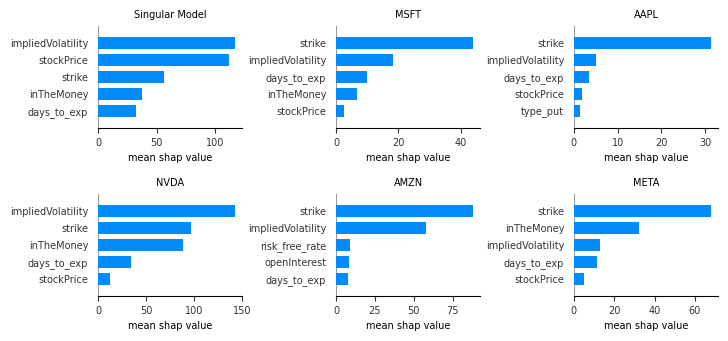

In [19]:
display(fig)

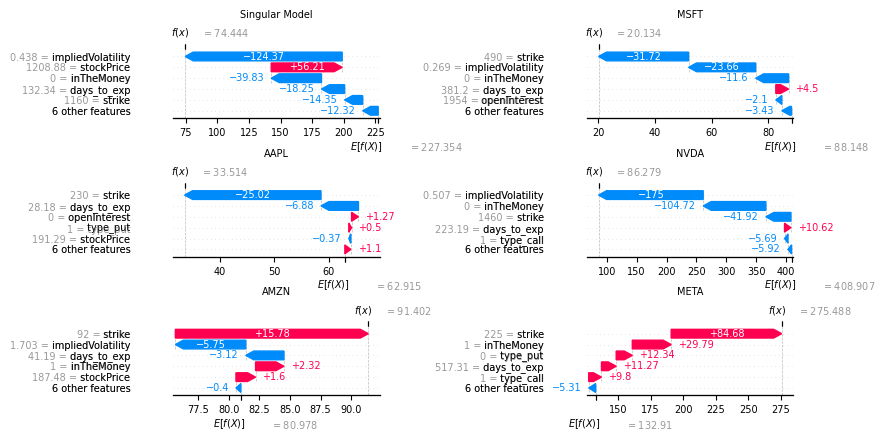

In [20]:
display(fig2)